In [2]:
import h5py 
import numpy as np
import os 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import matplotlib.colors as mcolors 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

use_tex = 0
plt.rcParams['text.usetex'] = use_tex
matplotlib.rcParams['font.size'] = 14         # overall font size
matplotlib.rcParams['axes.titlesize'] = 14    # size of the axes title
matplotlib.rcParams['axes.labelsize'] = 14    # size of the axis labels
matplotlib.rcParams['xtick.labelsize'] = 12   # size of the x-axis tick labels
matplotlib.rcParams['ytick.labelsize'] = 12   # size of the y-axis tick labels

plt.rcParams['figure.facecolor'] = '#ffffff'  
plt.rcParams['axes.facecolor'] = '#fafafa' 
plt.rcParams['axes.labelcolor'] = '222222'  
plt.rcParams['axes.titlecolor'] = '#000000' 
plt.rcParams['xtick.color'] = '#444444'  
plt.rcParams['ytick.color'] = '#444444'
plt.rcParams['legend.edgecolor'] = '#666666'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['grid.color'] = '#cccccc' 

cmp = cm.viridis 
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_viridis', cmp(np.linspace(0.0, 0.98, 256)))
colors = [cmap(0.0), cmap(0.5), cmap(0.9)]

# Plot the Subspace 

99.9013440587874


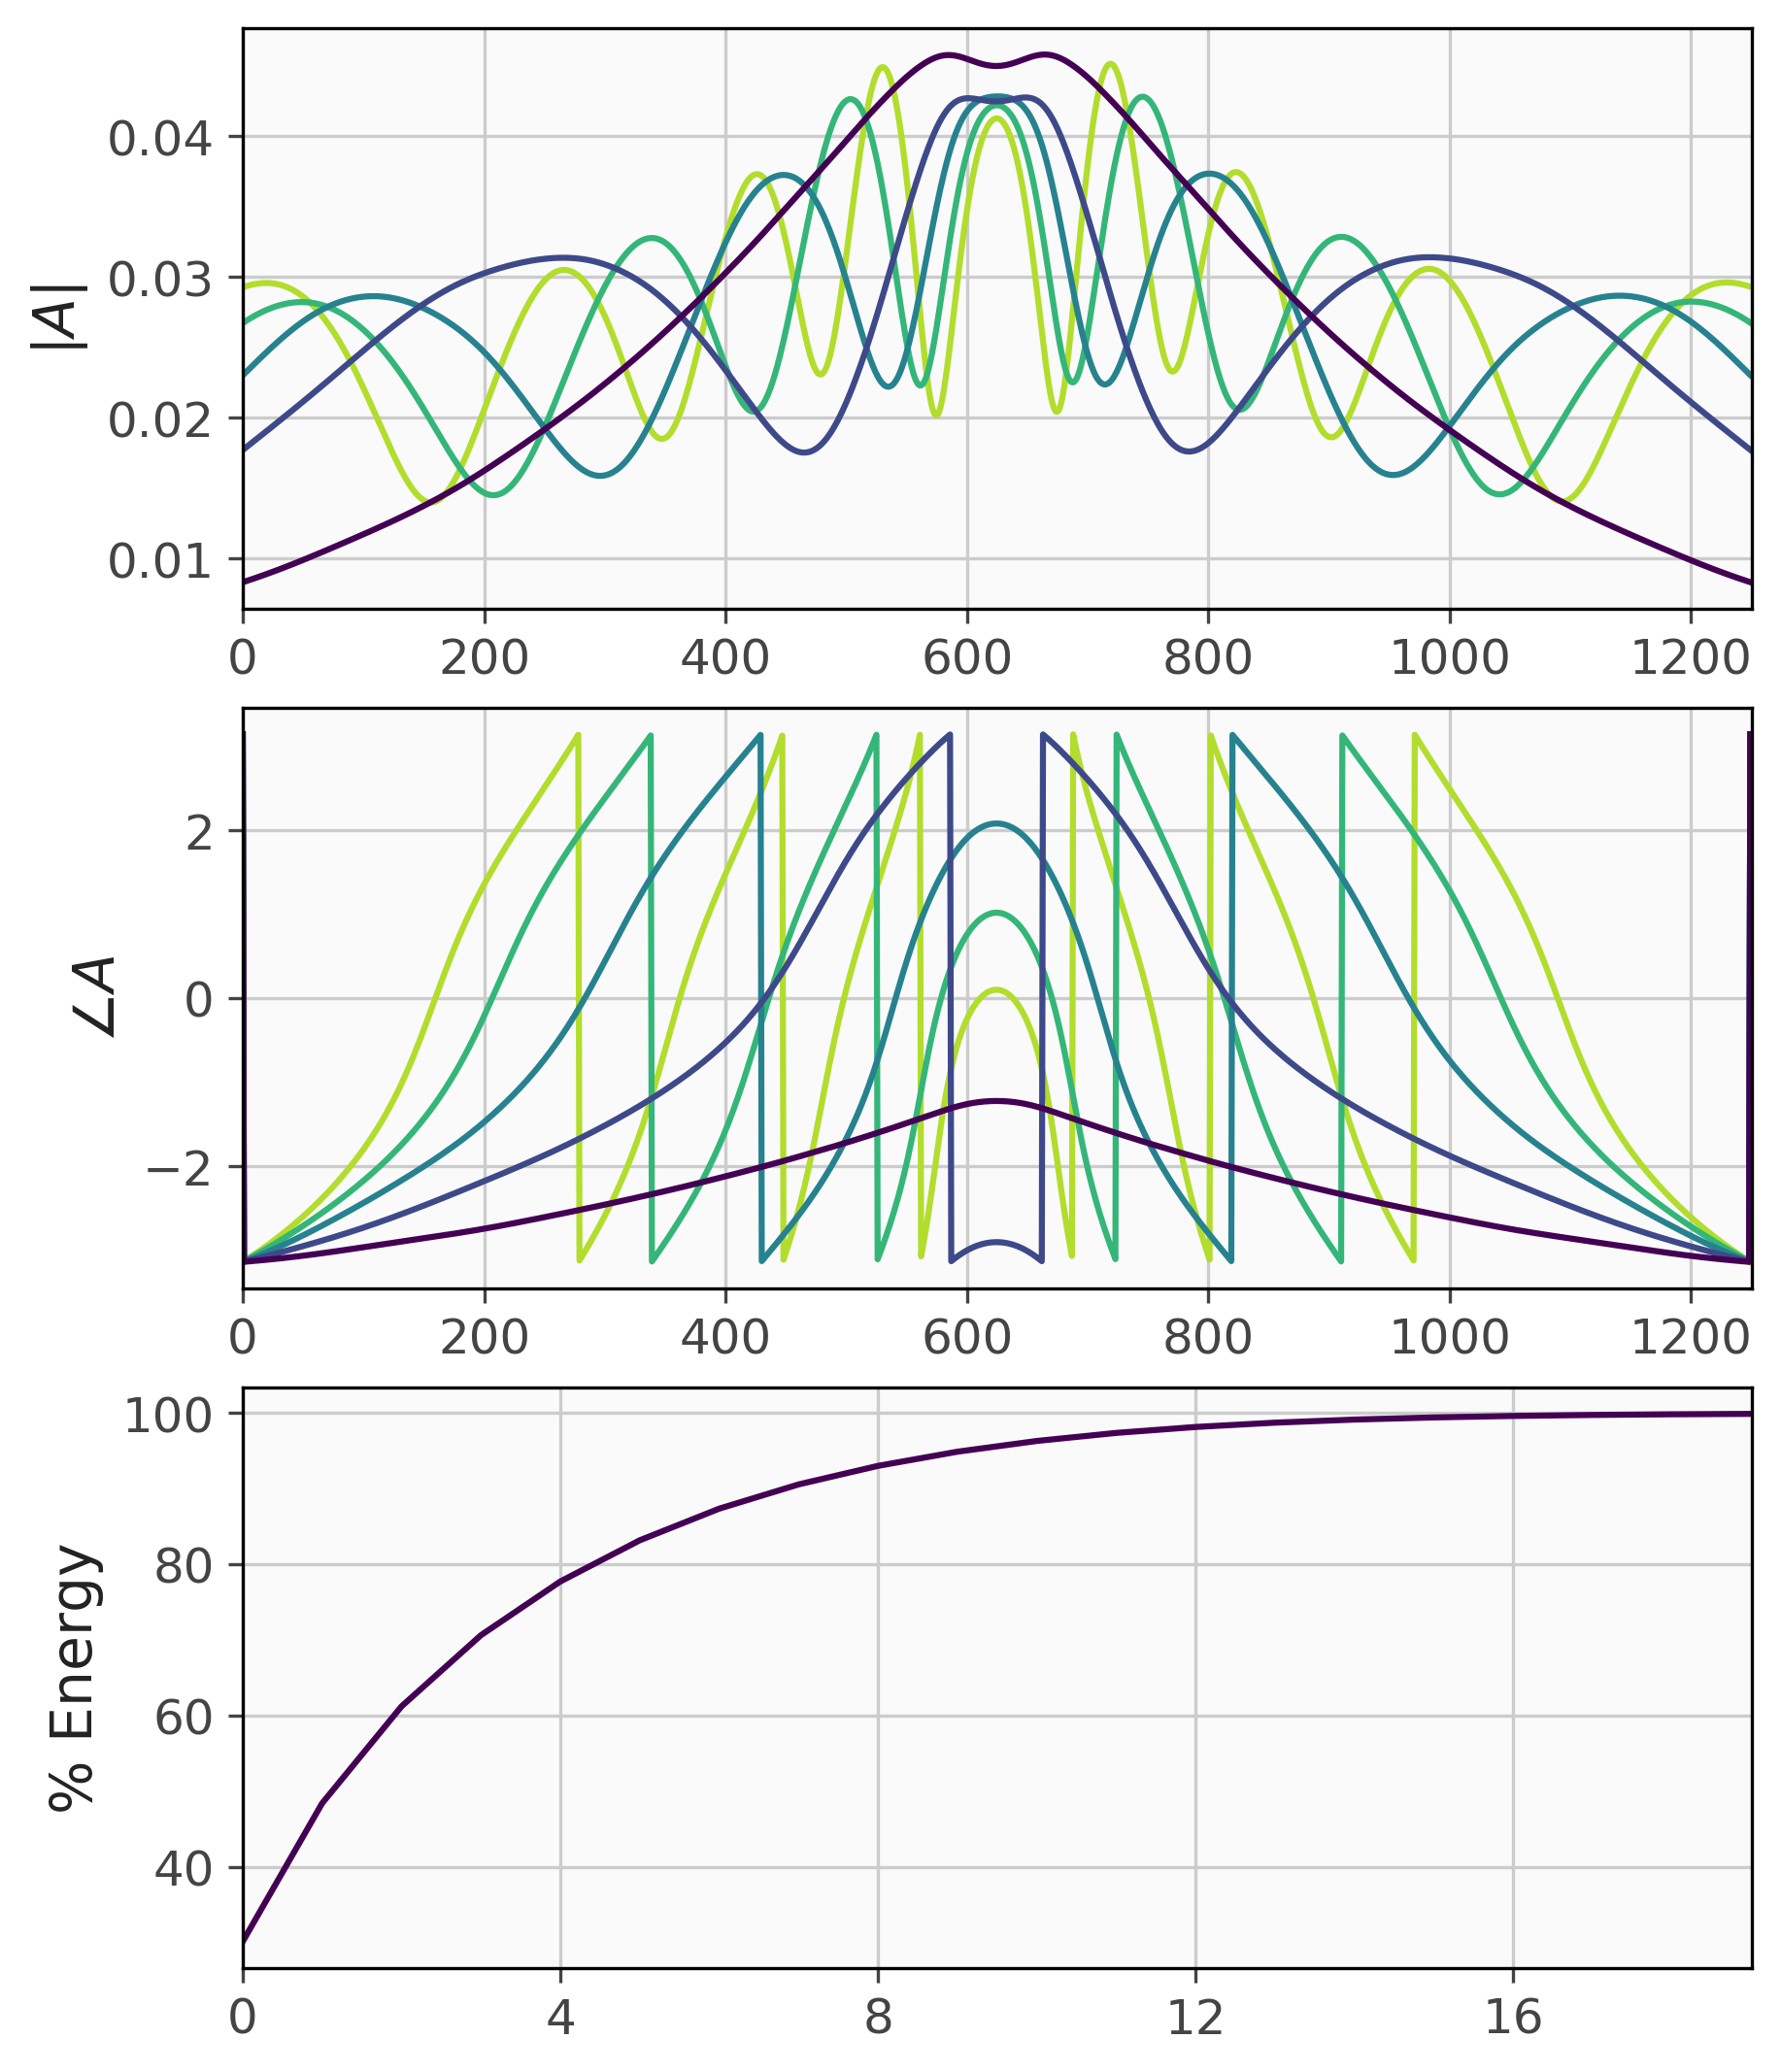

In [3]:
data_dir = 'data/sel_20250313_073618/'
data_file = os.path.join(data_dir, 'pulse_000.h5')

rank_plot = 5
rank = 20
basis_colors = cmap(np.linspace(0.0, 0.9, rank_plot))

with h5py.File(data_file,'r') as F:
    basis = np.array(F['basis'], dtype=np.complex128)
    s = np.array(F['s'], dtype=np.float64)
cumulative_energy = 100*np.cumsum(s)/np.sum(s)
print(cumulative_energy[rank])

fig,ax = plt.subplots(3, 1, figsize=(6,7), dpi=300, constrained_layout=True)
for b in range(rank_plot-1,-1,-1):
    ax[0].plot(np.abs(basis[:,b]), color=basis_colors[b])
    ax[0].set_xlim(0, basis.shape[0])
    ax[1].plot(np.angle(basis[:,b]), color=basis_colors[b])
    ax[1].set_xlim(0, basis.shape[0])
ax[0].grid()
ax[0].set_ylabel(r'$|A|$')
ax[1].grid()
ax[1].set_ylabel(r'$\angle{A}$')
ax[2].plot(cumulative_energy[:rank], color=basis_colors[0])
ax[2].set_xlim(0, rank-1)
ax[2].set_ylabel(r'$\mathrm{\%\ Energy}$')
ax[2].set_xticks(np.arange(0, rank, 4))
ax[2].grid()

figfile = os.path.join(data_dir, 'figure_subspace_%d.png'%(use_tex))
plt.savefig(figfile)
plt.show()


# Selective Inversion: Peak $B_1$ and Energy Reduction

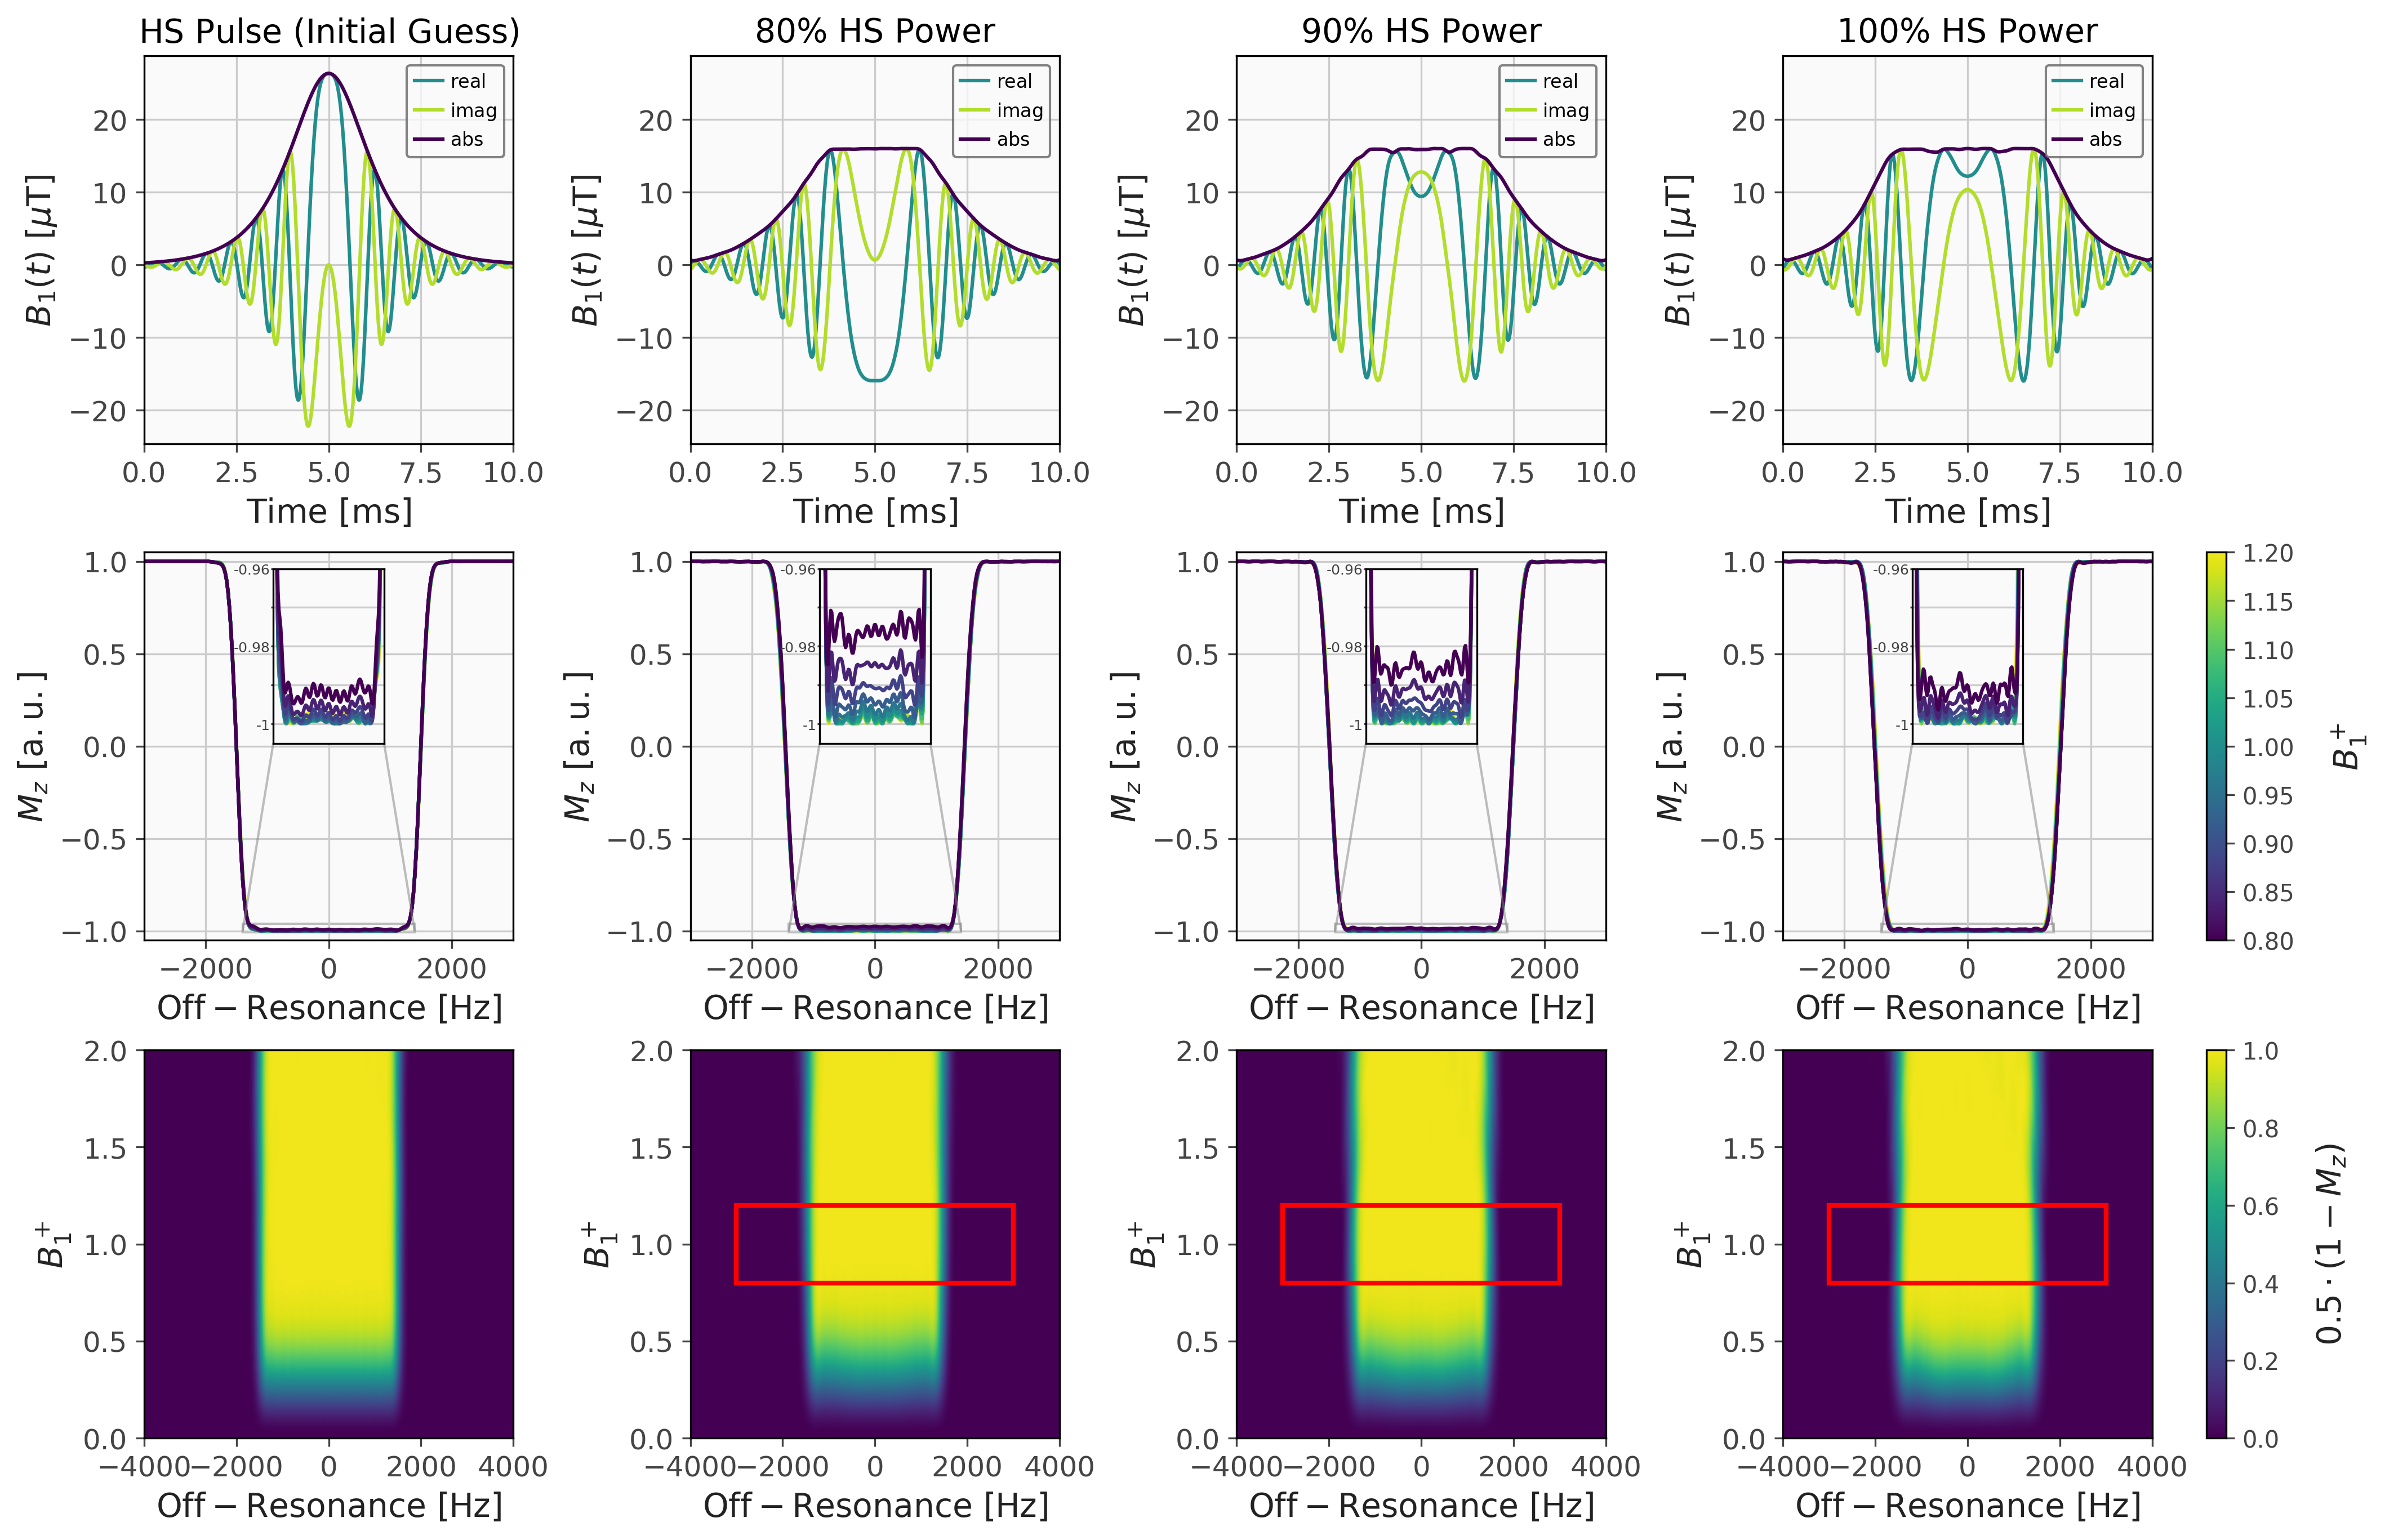

In [4]:
data_dir = 'data/sel_20250313_073618'
data_file = os.path.join(data_dir, 'eval_data.h5')

with h5py.File(data_file,'r') as F:
    num_pulses = F['num_pulses'][()]
    b1_design = np.array(F['b1_design'], dtype=np.float64)
    freq_design = np.array(F['freq_design'], dtype=np.float64)
    b1_eval = np.array(F['b1_eval'], dtype=np.float64)
    freq_eval = np.array(F['freq_eval'], dtype=np.float64)

    color_indices = np.linspace(0.0, 1.0, b1_design.size)
    norm = mcolors.Normalize(vmin=b1_design.min(), vmax=b1_design.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig,ax = plt.subplots(3, num_pulses, figsize=(14,9), dpi=300, constrained_layout=True)

    for p in range(num_pulses):

        rf = np.array(F['pulse_%i'%(p)], dtype=np.complex128)
        tv = np.array(F['tv_%i'%(p)], dtype=np.float64)
        dur = F['dur_%i'%(p)][()]
        mz = np.array(F['mz_%i'%(p)], dtype=np.float64)
        mz_eval = np.transpose(np.array(F['mz_eval_%i'%(p)], dtype=np.float64), (1,0))
        show_optimized_region = F['show_optimized_region_%i'%(p)][()]
        x_corner = F['x_corner_%i'%(p)][()]
        y_corner = F['y_corner_%i'%(p)][()]
        width = F['width_%i'%(p)][()]
        height = F['height_%i'%(p)][()]
        title = F['title_%i'%(p)][()].decode("utf-8")
        legend_loc = F['legend_loc_%i'%(p)][()].decode("utf-8")

        ax[0,p].plot(tv, np.real(rf), color=colors[1], label=r'$\mathrm{real}$')
        ax[0,p].plot(tv, np.imag(rf), color=colors[2], label=r'$\mathrm{imag}$')
        ax[0,p].plot(tv, np.abs(rf), color=colors[0], label=r'$\mathrm{abs}$')
        ax[0,p].set_ylabel(r'$B_1(t)\mathrm{\ [}\mu\mathrm{T]}$')
        ax[0,p].set_xlabel(r'$\mathrm{Time\ [ms]}$')
        ax[0,p].set_xlim(0, dur)
        if p > 0:
            ax[0,p].set_ylim(ax[0,0].get_ylim())
        ax[0,p].grid()
        ax[0,p].legend(loc=legend_loc, fontsize=8, handlelength=1.5, handletextpad=0.4)
        ax[0,p].set_title(r'%s'%(title))

        for n in range(mz.shape[1]-1,-1,-1):
            ax[1,p].plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        ax[1,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        ax[1,p].set_ylabel(r'$M_z\mathrm{\ [a.u.]}$')
        ax[1,p].set_xlim(freq_design.min(), freq_design.max())
        ax[1,p].set_ylim(-1.05, 1.05)
        ax[1,p].grid()

        inax = inset_axes(ax[1,p], width='30%', height='45%', loc='upper center')
        for n in range(mz.shape[1]-1,-1,-1):
            inax.plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        inax.set_xlim(-1400, 1400)
        inax.set_ylim(-1.005, -0.96)
        inax.tick_params(axis='x', labelsize=6)
        inax.tick_params(axis='y', labelsize=6, pad=0.25, length=1)
        inax.set_yticks([-1, -0.99, -0.98, -0.97, -0.96])
        inax.set_yticklabels(['-1', '', '-0.98', '', '-0.96'])
        inax.set_xticks([])
        inax.set_xticklabels([])
        inax.grid()
        mark_inset(ax[1,p], inax, loc1=3, loc2=4, ec='gray', alpha=0.5)

        img = ax[2,p].imshow((1-mz_eval)/2, vmin=0.0, vmax=1.0, cmap=cmap, extent=[freq_eval.min(), freq_eval.max(), b1_eval.min(), b1_eval.max()], origin='lower')
        ax[2,p].set_aspect('auto')
        ax[2,p].set_ylabel(r'$B_1^+$')
        ax[2,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        if show_optimized_region:
            rect = matplotlib.patches.Rectangle((x_corner, y_corner), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax[2,p].add_patch(rect)
        
    cbar1 = fig.colorbar(sm, ax=ax[1,-1])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(r'$B_1^+$', labelpad=15)

    cbar2 = fig.colorbar(img, ax=ax[2,-1])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(r'$0.5\cdot (1 - M_z)$', labelpad=15)

    figfile = os.path.join(data_dir, 'figure_selective_%d.png'%(use_tex))
    plt.savefig(figfile)
    plt.show()

# Non-Selective Inversion w/ Comparison to Graf et. al. 

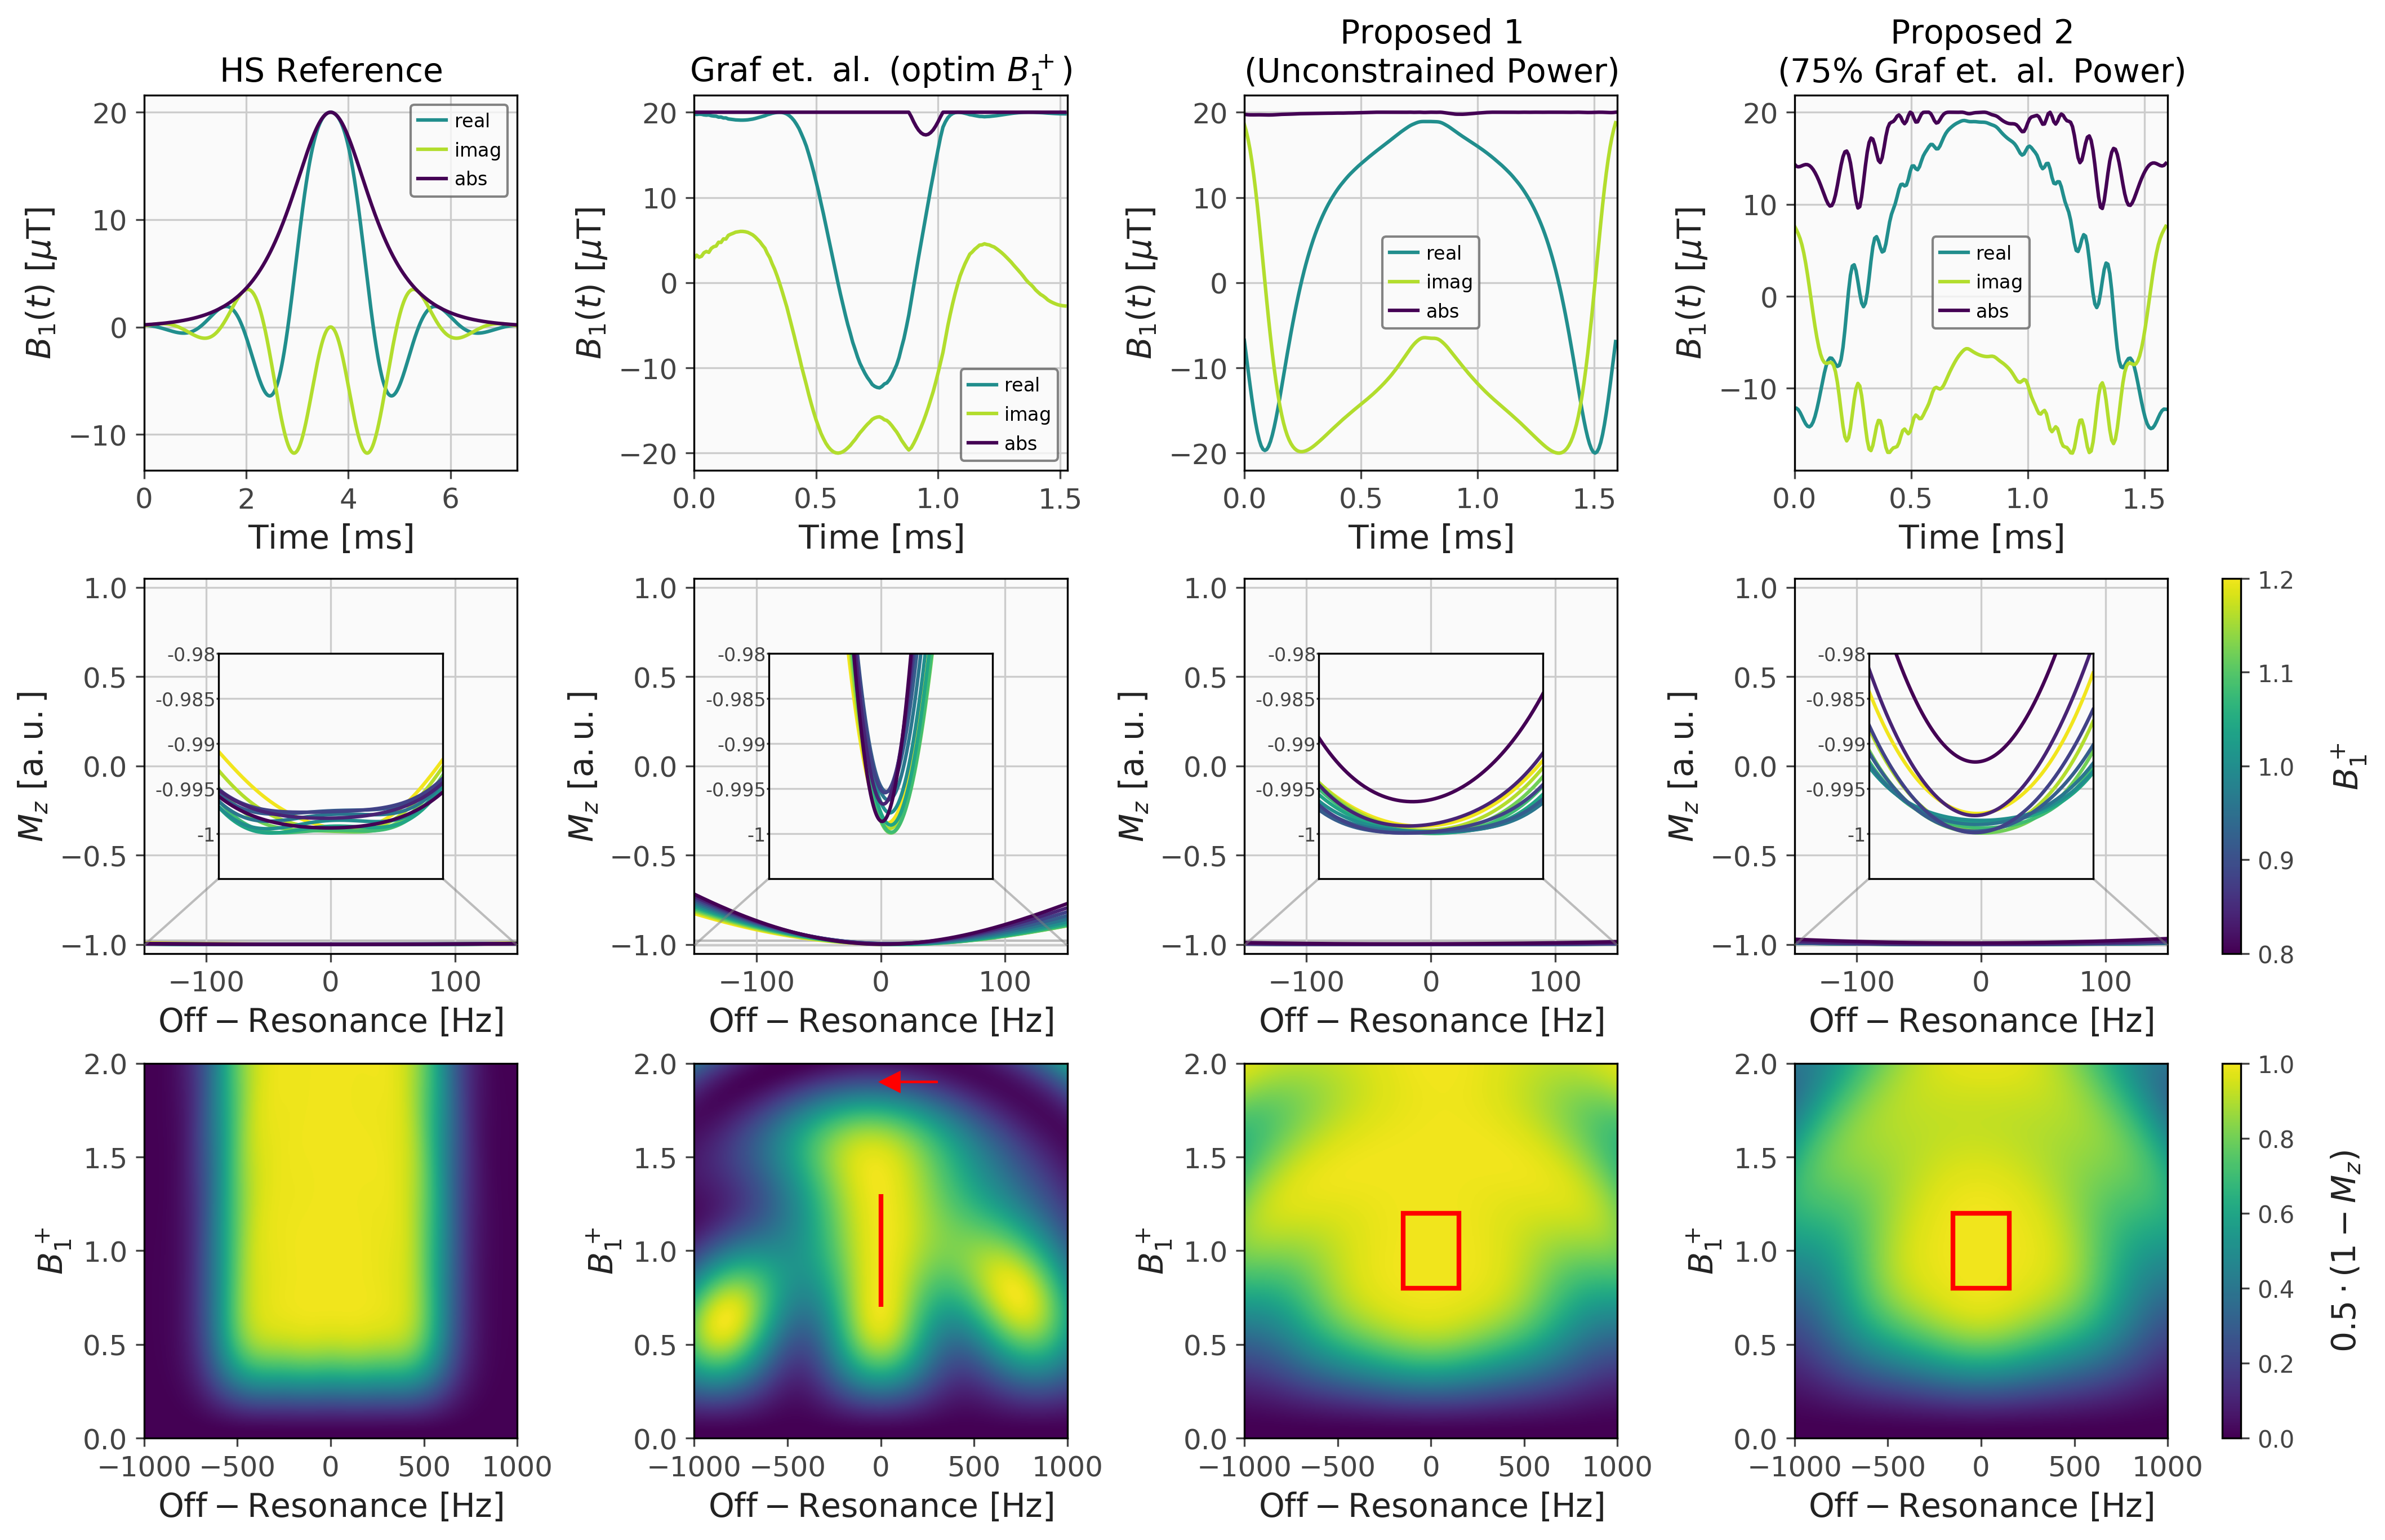

In [5]:
# data_dir = 'data/nonsel_20250313_072103' 
data_dir = 'data/nonsel_20250313_163627'
data_file = os.path.join(data_dir, 'eval_data.h5')

with h5py.File(data_file,'r') as F:
    num_pulses = F['num_pulses'][()]
    b1_design = np.array(F['b1_design'], dtype=np.float64)
    freq_design = np.array(F['freq_design'], dtype=np.float64)
    b1_eval = np.array(F['b1_eval'], dtype=np.float64)
    freq_eval = np.array(F['freq_eval'], dtype=np.float64)

    color_indices = np.linspace(0.0, 1.0, b1_design.size)
    norm = mcolors.Normalize(vmin=b1_design.min(), vmax=b1_design.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig,ax = plt.subplots(3, num_pulses, figsize=(14,9), dpi=300, constrained_layout=True)

    for p in range(num_pulses):

        rf = np.array(F['pulse_%i'%(p)], dtype=np.complex128)
        tv = np.array(F['tv_%i'%(p)], dtype=np.float64)
        dur = F['dur_%i'%(p)][()]
        mz = np.array(F['mz_%i'%(p)], dtype=np.float64)
        mz_eval = np.transpose(np.array(F['mz_eval_%i'%(p)], dtype=np.float64), (1,0))
        show_optimized_region = F['show_optimized_region_%i'%(p)][()]
        x_corner = F['x_corner_%i'%(p)][()]
        y_corner = F['y_corner_%i'%(p)][()]
        width = F['width_%i'%(p)][()]
        height = F['height_%i'%(p)][()]
        title = F['title_%i'%(p)][()].decode("utf-8")
        legend_loc = F['legend_loc_%i'%(p)][()].decode("utf-8")

        ax[0,p].plot(tv, np.real(rf), color=colors[1], label=r'$\mathrm{real}$')
        ax[0,p].plot(tv, np.imag(rf), color=colors[2], label=r'$\mathrm{imag}$')
        ax[0,p].plot(tv, np.abs(rf), color=colors[0], label=r'$\mathrm{abs}$')
        ax[0,p].set_ylabel(r'$B_1(t)\mathrm{\ [}\mu\mathrm{T]}$')
        ax[0,p].set_xlabel(r'$\mathrm{Time\ [ms]}$')
        ax[0,p].set_xlim(0, dur)
        ax[0,p].grid()
        ax[0,p].legend(loc=legend_loc, fontsize=8, handlelength=1.5, handletextpad=0.4)
        ax[0,p].set_title(r'%s'%(title))

        for n in range(mz.shape[1]-1,-1,-1):
            ax[1,p].plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        ax[1,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        ax[1,p].set_ylabel(r'$M_z\mathrm{\ [a.u.]}$')
        ax[1,p].set_xlim(freq_design.min(), freq_design.max())
        ax[1,p].set_ylim(-1.05, 1.05)
        ax[1,p].grid()

        inax = inset_axes(ax[1,p], width='60%', height='60%', loc='center')
        for n in range(mz.shape[1]-1,-1,-1):
            inax.plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        inax.set_xlim(ax[1,p].get_xlim())
        inax.set_ylim(-1.005, -0.98)
        inax.tick_params(axis='x', labelsize=8)
        inax.tick_params(axis='y', labelsize=8, pad=0.25, length=1)
        inax.set_yticks([-1, -0.995, -0.99, -0.985, -0.98])
        inax.set_yticklabels(['-1', '-0.995', '-0.99', '-0.985', '-0.98'])
        inax.set_xticks([])
        inax.set_xticklabels([])
        inax.grid()
        mark_inset(ax[1,p], inax, loc1=3, loc2=4, ec='gray', alpha=0.5)

        img = ax[2,p].imshow((1-mz_eval)/2, vmin=0.0, vmax=1.0, cmap=cmap, extent=[freq_eval.min(), freq_eval.max(), b1_eval.min(), b1_eval.max()], origin='lower')
        ax[2,p].set_aspect('auto')
        ax[2,p].set_ylabel(r'$B_1^+$')
        ax[2,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        if show_optimized_region:
            rect = matplotlib.patches.Rectangle((x_corner, y_corner), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax[2,p].add_patch(rect)
    
    ax[2,1].arrow(300.0, 1.9, -200.0, 0.0, head_width=0.1, head_length=100.0, fc='red', ec='red')
        
    cbar1 = fig.colorbar(sm, ax=ax[1,-1])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(r'$B_1^+$', labelpad=15)

    cbar2 = fig.colorbar(img, ax=ax[2,-1])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(r'$0.5\cdot (1 - M_z)$', labelpad=15)

    figfile = os.path.join(data_dir, 'figure_non-selective_%d.png'%(use_tex))
    plt.savefig(figfile)
    plt.show()

